In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.2 MB/s eta 0:00:00


In [2]:
!python -m spacy download en_core_web_lg -q

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-18 19:24:48.346633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 19:24:50.757681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-18 19:24:50.757861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

In [3]:
import pandas as pd
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve

import tensorflow_datasets as tfds
import tensorflow as tf 
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from keras.utils import pad_sequences
import tensorflow_addons as tfa

import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import json

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
# Loading dataset
url = 'https://attspamdetector.s3.eu-west-3.amazonaws.com/spam.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")

In [5]:
# Viewing several lines of the dataset
df.head()
# "ham" messages are those that are not spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.shape

(5572, 5)

In [7]:
# Checking that there are only two types of labels
df['v1'].nunique()

2

In [8]:
# Checking if there are any missing values
100*df.isnull().sum()/df.shape[0]

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

Most values in the columns 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4' are missing. Let us have a look at what remains in these columns.

In [9]:
unnamed_cols = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

for col in unnamed_cols:
  print(f"Number of non-empty values in column '{col}': {df[col].count()}")
  nonempty_indexes = df[col].notnull().where(lambda x: x).dropna().index
  print(nonempty_indexes)
  print()

Number of non-empty values in column 'Unnamed: 2': 50
Int64Index([  95,  281,  444,  671,  710,  899, 1038, 1127, 1266, 1384, 1428,
            1559, 1637, 1669, 1675, 1936, 1937, 1997, 2087, 2170, 2235, 2255,
            2406, 2791, 2970, 3110, 3145, 3239, 3506, 3525, 3547, 3640, 3758,
            3788, 3793, 3881, 4130, 4224, 4454, 4455, 4570, 4601, 4668, 4859,
            4992, 5048, 5079, 5081, 5264, 5268],
           dtype='int64')

Number of non-empty values in column 'Unnamed: 3': 12
Int64Index([95, 281, 899, 1038, 2170, 2255, 3145, 3506, 3525, 4668, 5048,
            5081],
           dtype='int64')

Number of non-empty values in column 'Unnamed: 4': 6
Int64Index([281, 1038, 2255, 3525, 4668, 5048], dtype='int64')



It looks like some indexes are repeated. I suppose that in some cases messages were split between several columns, so that the beginning of the message is in one column, the continuation in the second column and the end in the third column. Let us print the text in each column for one of the rows to check this idea.

In [10]:
print(df.loc[4668, 'v2'])
print(df.loc[4668, 'Unnamed: 2'])
print(df.loc[4668, 'Unnamed: 3'])
print(df.loc[4668, 'Unnamed: 4'])

When I was born, GOD said, \Oh No! Another IDIOT\". When you were born
 GOD said
 \"OH No! COMPETITION\". Who knew
 one day these two will become FREINDS FOREVER!"


It seem that this is the case. Let us assemble the whole text into one column.

In [11]:
# Replacing all NaN values with spaces to make concatenation of strings easier.
# Extra spaces will be removed during further preprocessing.
df = df.fillna(' ')

# Concatenating strings contained in different columns of the same row.
# We add spaces between parts of strings taken from different columns 
#to avoid words found at the end of one sting and at the beginning of the of the other sting 
# being glued together (e.g. thedog)
df['text'] = df['v2'].astype(str) + " " + df['Unnamed: 2'].astype(str) + " " + df['Unnamed: 3'].astype(str) + " " + df['Unnamed: 4'].astype(str)

In [12]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,text
0,ham,"Go until jurong point, crazy.. Available only ...",,,,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,,,,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,,,,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# Taking one of the rows to check the result
df.loc[4668, 'text']

'When I was born, GOD said, \\Oh No! Another IDIOT\\". When you were born  GOD said  \\"OH No! COMPETITION\\". Who knew  one day these two will become FREINDS FOREVER!"'

In [14]:
df.loc[1, 'text']

'Ok lar... Joking wif u oni...      '

In [15]:
# Dropping useless columns
df = df.drop(['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

# Renaming column to give it a more explicit name
df.rename(columns = {"v1" : "label"}, inplace = True)

# Encoding values in column "label": 0 for non-spam messages, 1 for spam
df["label"] = df["label"].apply(lambda x: 0 if x=="ham" else 1)

# Checking the result
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# Checking how many spam vs non-spam messages there are
(df["label"]).value_counts()/len(df)*100

0    86.593683
1    13.406317
Name: label, dtype: float64

In [17]:
# Computing weights to attribute to each class
weights = 1/(df["label"]).value_counts()
weights = weights * len(df)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.5774093264248704, 1: 3.72958500669344}

### Text cleaning

In [18]:
# Creating an nlp object
nlp = en_core_web_lg.load()

# Removing punctuation except for apostrophes
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))

# Removing multiple spaces, converting all characters to lower case and trimming starting and finishing whitespaces.
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace("  "," ").lower().strip())

# Lemmatizing text and removing stop words
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [19]:
df.head()

,label,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [20]:
# Looking at the initial version of the texts
for i in range(0, 10):
  print(df["label"].loc[i], df["text"].loc[i])

0 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...      
0 Ok lar... Joking wif u oni...      
1 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's      
0 U dun say so early hor... U c already then say...      
0 Nah I don't think he goes to usf, he lives around here though      
1 FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv      
0 Even my brother is not like to speak with me. They treat me like aids patent.      
0 As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune      
1 WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341

In [21]:
# Looking at the result of the preprocessings
for i in range(0, 15):
  print(df["text_clean"].loc[i])

jurong point crazy available bugis n great world la e buffet cine amore wat
ok lar joke wif u oni
free entry 2 wkly comp win fa cup final tkts 21st 2005 text fa 87121 receive entry questionstd txt ratetc apply 08452810075over18
u dun early hor u c
nah think usf live
freemsg hey darle 3 week word like fun tb ok xxx std chgs send å150 rcv
brother like speak treat like aid patent
request ' melle melle oru minnaminunginte nurungu vettam ' set callertune caller press 9 copy friend callertune
winner value network customer select receivea å900 prize reward claim 09061701461 claim code kl341 valid 12 hour
mobile 11 month u r entitle update late colour mobile camera free mobile update co free 08002986030
home soon want talk stuff anymore tonight k cry today
chance win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6days 16 tsandc apply reply hl 4 info
urgent win 1 week free membership å100000 prize jackpot txt word claim 81010 tc wwwdbuknet lccltd pobox 4403ldnw1a7rw18
search right word

In [22]:
# Checking if any text were erased after text cleaning
erased_texts_indexes = []
for i in range(0, len(df)):
  if len(df["text_clean"].loc[i].split())==0:
    erased_texts_indexes.append(i)

print(erased_texts_indexes)


[43, 959, 1087, 1190, 1236, 1407, 2096, 2740, 2805, 2871, 2927, 3374, 3767, 4271, 4573, 4640, 4822, 5529]


In [23]:
# Dropping rows where the texts were erased
df.drop(axis=0, index=erased_texts_indexes, inplace=True)
df.reset_index(inplace=True)

In [24]:
# Saving text of sms messages as numpy array
texts = df["text_clean"].values
print(texts[:5])

# Saving labels as numpy array
labels = df["label"].values
print(labels[:5])

['jurong point crazy available bugis n great world la e buffet cine amore wat'
 'ok lar joke wif u oni'
 'free entry 2 wkly comp win fa cup final tkts 21st 2005 text fa 87121 receive entry questionstd txt ratetc apply 08452810075over18'
 'u dun early hor u c' 'nah think usf live']
[0 0 1 0 0]


In [25]:
# Splitting the arrays into training and testing datasets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.15, stratify=labels, random_state=42)

In [26]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts_train)

In [27]:
texts_train = tokenizer.texts_to_sequences(texts_train)
texts_test = tokenizer.texts_to_sequences(texts_test)
print(texts_test[0:5])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

texts_train = pad_sequences(texts_train, padding='post', maxlen=maxlen)
texts_test = pad_sequences(texts_test, padding='post', maxlen=maxlen)
print(texts_test[0:3])

[[18, 1, 2, 6450, 46, 433, 79, 1, 2, 332, 3, 30, 1722, 346, 6451, 1941], [296, 1, 166, 1134, 176, 296, 296, 7, 296, 955, 330, 956, 4, 163, 1680, 1681, 377, 1682, 397], [143, 1059, 103, 2288, 31, 432, 7147, 31, 762, 103, 37, 432, 7147, 31, 1144, 7147], [49, 123, 207, 129], [2289, 2, 4470, 65, 539]]
[[  18    1    2 6450   46  433   79    1    2  332    3   30 1722  346
  6451 1941    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  

In [28]:
"""# Instanciating tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df["text_clean"])

# Converting texts to sequences of numbers
df["text_encoded"] = tokenizer.texts_to_sequences(df["text_clean"])

# Checking the result
df.head()"""

'# Instanciating tokenizer\ntokenizer = tf.keras.preprocessing.text.Tokenizer()\ntokenizer.fit_on_texts(df["text_clean"])\n\n# Converting texts to sequences of numbers\ndf["text_encoded"] = tokenizer.texts_to_sequences(df["text_clean"])\n\n# Checking the result\ndf.head()'

In [29]:
"""# Padding: adding zeros at the end of sequences so that they all have the same length
text_pad = tf.keras.preprocessing.sequence.pad_sequences(df["text_encoded"], padding="post")"""

'# Padding: adding zeros at the end of sequences so that they all have the same length\ntext_pad = tf.keras.preprocessing.sequence.pad_sequences(df["text_encoded"], padding="post")'

In [30]:
"""# Converting texts and labels into a tensor slice dataset 
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, df["label"]))"""

'# Converting texts and labels into a tensor slice dataset \nfull_ds = tf.data.Dataset.from_tensor_slices((text_pad, df["label"]))'

In [31]:
"""# Splitting dataset into train and test datasets
TAKE_SIZE = int(0.7*df.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(16)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(16)"""

'# Splitting dataset into train and test datasets\nTAKE_SIZE = int(0.7*df.shape[0])\n\ntrain_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)\ntrain_data = train_data.batch(16)\n\ntest_data = full_ds.skip(TAKE_SIZE)\ntest_data = test_data.batch(16)'

In [32]:
"""# Having a look at one batch of the training set:
for text, text_type in train_data.take(1):
  print(text, text_type)"""

'# Having a look at one batch of the training set:\nfor text, text_type in train_data.take(1):\n  print(text, text_type)'

In [33]:
"""# Checking the type of a trainig data batch
print(type(text))

# Checking the shape of a batch
text.shape"""

'# Checking the type of a trainig data batch\nprint(type(text))\n\n# Checking the shape of a batch\ntext.shape'

Modeling

In [34]:
vocab_size = len(tokenizer.word_index)

model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 16, name="embedding"),
                  LSTM(units=16, return_sequences=True, name = "ltsm_1"), # maintains the sequential nature
                  LSTM(units=16, return_sequences=False, name = "lstm_2"), # returns the last output
                  Dense(16, activation='relu', name = "dense_1"),
                  Dropout(0.25), # during every training, 4 neurons are dropped out
                  Dense(4, activation='relu'),
                  Dropout(0.25), # during every training, 1 neuron is dropped out
                  Dense(1, activation="sigmoid", name="last") # 1 neuron with sigmoid activation for binary classification
                  ])

In [35]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          120624    
                                                                 
 ltsm_1 (LSTM)               (None, None, 16)          2112      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0

In [36]:
# Compiling the model with the Adam optimizer
optimizer= tf.keras.optimizers.Adam(learning_rate=2e-5)

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC()])

In [37]:
#history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

In [38]:
# Training model
model_lstm.fit(texts_train, labels_train, 
               batch_size = 64, epochs = 20,
               validation_split = 0.2, 
               class_weight=weights)

Epoch 1/20
59/59 [==============================] - 14s 142ms/step - loss: 0.6854 - binary_accuracy: 0.3114 - precision: 0.1348 - recall: 0.7890 - auc: 0.5189 - val_loss: 0.6970 - val_binary_accuracy: 0.1504 - val_precision: 0.1504 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
59/59 [==============================] - 9s 149ms/step - loss: 0.6855 - binary_accuracy: 0.3377 - precision: 0.1317 - recall: 0.7282 - auc: 0.5086 - val_loss: 0.6965 - val_binary_accuracy: 0.1504 - val_precision: 0.1504 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
59/59 [==============================] - 8s 144ms/step - loss: 0.6857 - binary_accuracy: 0.3573 - precision: 0.1237 - recall: 0.6450 - auc: 0.4902 - val_loss: 0.6963 - val_binary_accuracy: 0.1504 - val_precision: 0.1504 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/20
59/59 [==============================] - 8s 126ms/step - loss: 0.6855 - binary_accuracy: 0.3755 - precision: 0.1353 - recall: 0.7018 - auc: 0.5072 - val_loss: 0.6961 - val_binary

In [39]:
# Saving model history as .json file
json.dump(model_lstm.history.history, open("/content/LSTM_history.json", 'w'))

In [40]:
# Loading model history to plot performance over epochs
LSTM_history = json.load(open("/content/LSTM_history.json", 'r'))

In [41]:
# Plotting loss over epochs
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=LSTM_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


In [42]:
# Plotting binary accuracy over epochs
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy'))
fig.add_trace(go.Scatter(y=LSTM_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy'))
fig.show()

In [43]:
score = model_lstm.evaluate(x=texts_test, y=labels_test, verbose=1)

27/27 [==============================] - 1s 32ms/step - loss: 0.6924 - binary_accuracy: 0.8657 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000


In [44]:
#Predicting the test data
predicted_labels = model_lstm.predict(texts_test)

predicted_labels[0:10]

27/27 [==============================] - 2s 30ms/step


array([[0.4994703],
       [0.4994703],
       [0.4994703],
       [0.4994703],
       [0.4994703],
       [0.4994703],
       [0.4994703],
       [0.4994703],
       [0.4994703],
       [0.4994703]], dtype=float32)

In [45]:
# Convert predicted probabilities to binary labels
predicted_labels = (predicted_labels > 0.5).astype(int)

predicted_labels[0:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [46]:
# Displaying the classification report
print(classification_report(labels_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       722
           1       0.00      0.00      0.00       112

    accuracy                           0.87       834
   macro avg       0.43      0.50      0.46       834
weighted avg       0.75      0.87      0.80       834



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

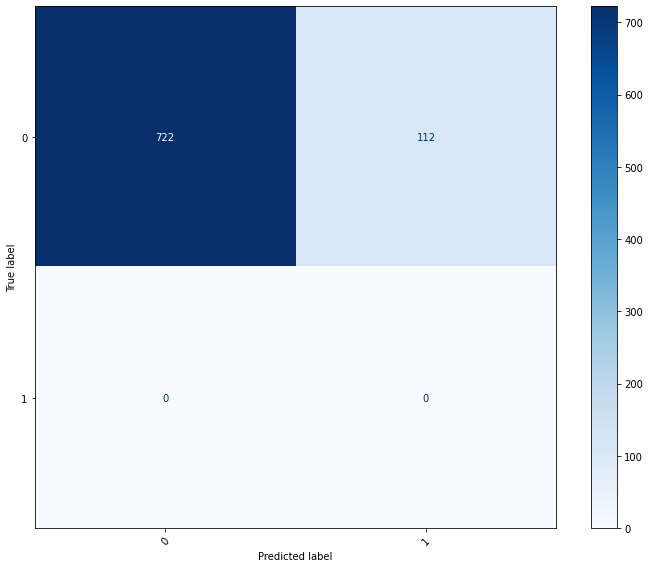

In [47]:
# Plotting a confusion matrix
cm = confusion_matrix(predicted_labels, labels_test)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black", 'xtick.color': "black", 'ytick.color': "black"})
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('white')
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation = 45)